# Model Analysis
In this notebook we test different machine learning methods, features and parameters in order to find the most ‘exact’ and suitable model for matchday predictions for the la quiniela game. This final summary of the tests and experiments we performed is structured as follows. 

Step 1: First we will describe how we preprocess the data in order to clean and extend the data and what features we add that we found interesting and promising. Here we also split the data into training and testing data to evaluate the different models and their accuracy.<br>
Step 2: Secondly we find the most important features that give the best accuracy across a selection of ML methods by comparing the prediction accuracy for random sets of features. From these we select the 5 most accurate feature sets and perform a hyperparameter optimization to find the best parameters for the corresponding ML method.<br>
Step 3: We then compare 4 models with these 5 feature sets with their optimised hyper parameters by comparing their accuracy and confusion matrices in order to find the best model. This model will be the model for our final implementation.<br>
Step 4: In this step we will evaluate the final model and show an example.


## Step 1: Data Preprocessing
The first part of this research is to have a correct dataset to use for training and testing. To do that, we will first clean the given dataset, and extend it with more data that we think to be interesting and useful. After that, we will decide which seasons we will train the model on, and on which one(s) we want to test it. The last thing we have to decide is if we want to resample or subsample to make sure that the dataset is balanced. All of this will be explained in this part.

In [50]:
# import libraries ncessary for data cleaning and extending
import pandas as pd
import numpy as np
import sqlite3

# import library for resampling data
from sklearn.utils import resample

In [51]:
# create a connection with the given database
con = sqlite3.connect("../laliga.sqlite")

# read the matches and the predictions table from the database into Pandas DataFrames
df_matches = pd.read_sql_query("SELECT * from Matches", con)
df_predictions = pd.read_sql_query("SELECT * from Predictions", con)

# close the connection of the database
con.close()

In [52]:
def count_points(last_5):
    """
    Calculate the amount of points in the last 5 games accumulated

    :param last_5: list of the last 5 results of a team. Example: ['W', 'W', 'T', 'L', 'W']

    :return: the amount of points in the last 5 games accumulated
    """
    # if there is no last 5 list, return 0
    if last_5 == 0:
        return 0

    # initialize a count variable
    count = 0
    # go trough all the elements of the last_5 list
    for i in last_5:
        # if the element is a win, add 3 to the count
        if i == 'W':
            count += 3
        # if the element is a tie, add 1 to the count
        elif i == 'T':
            count += 1
    return count

First, it was necessary to transform the provided data into more appropriate structures and variable types for analysis, particularly regarding the date and time columns. The score columns were split into home and away scores to help identify the winners in matches.

To improve the data, a winner column was created to indicate whether a team had a home win, an away win, or if there was a tie. Additionally, recycling one of the analyses from part one, statistics for goals scored (GF) were added, calculated by summing the goals scored in each match progressively. Goals conceded (GA), similar to goals scored, tracks the total number of goals conceded by maintaining a running total. Wins (W), losses (L), and ties (T) were recorded by matchday, division, and season. Columns like “prev_last_5_diff” were included to calculate the difference in performance over the last five matches for both teams. Head-to-head statistics were created using groupby functions combined with rolling calculations. Finally, the “prev_rank_diff” was established to measure the difference in ranking between the home and away teams prior to the match.

In [1]:
def extend_data(input_data):
    """
    Main function that cleans and extends the data.
    It adds features to the data that we want to use.

    :param input_data: the data to be cleaned and extended

    :return: the cleaned and extended data
    """
    # clean the inputted dataframe
    # make a copy of the data so the original dataframe does not change
    data = input_data.copy()
    
    # drop the "time" column because it contains to many "None" values, and the "date" column because it is not used
    data.drop(columns = ['time', 'date'], inplace = True)
    
    # drop NaN values (there are only NaN values left in the "score" column)
    data.dropna(inplace = True)
    
    # create two new columns, one for the score of the home team, and one for the score of the away team, drop the score column
    data[['home_score', 'away_score']] = data['score'].str.split(':', expand=True).astype(int)
    data.drop(columns=['score'], inplace = True)
    
    # create a new column to show which team won (1 for home team, 2 for away team and 'X' for a draw)
    data['winner'] = data.apply(lambda row: 1 if row['home_score'] > row['away_score'] else 2 if row['home_score'] < row['away_score'] else 'X', axis=1)


    # use the code from exercise 10 to gather more data for the matches
    # make a copy of the data dataframe so the original dataframe does not change
    data_copy = data

    # calculate, for every unique group of season, division, matchday and home_team, how many goals the team made (GF) and got against (GA)
    # and if the team won (W=1), lost (L=1) or tied (T=1)
    home_stats = data_copy.groupby(['season', 'division', 'matchday', 'home_team']).agg(
        GF=('home_score', 'sum'), GA=('away_score', 'sum'),
        W=('winner', lambda x: (x == 1).sum()),
        L=('winner', lambda x: (x == 2).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'home_team': 'team', 'result': 'home_result'})

    # calculate, for every unique group of season, division, matchday and away_team, how many goals the team made (GF) and got against (GA)
    # and if the team won (W=1), lost (L=1) or tied (T=1)
    away_stats = data_copy.groupby(['season', 'division', 'matchday', 'away_team']).agg(
        GF=('away_score', 'sum'), GA=('home_score', 'sum'),
        W=('winner', lambda x: (x == 2).sum()),
        L=('winner', lambda x: (x == 1).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'away_team': 'team', 'result': 'away_result'})

    
    # add the statestics for the home teams and the away teams together
    combined_stats = pd.concat([home_stats, away_stats]).fillna(0)
    # calculate the goal difference for each row, a negative goal difference means the team got more goals against then that it made
    combined_stats['GD'] = combined_stats['GF'] - combined_stats['GA']
    # calculate the amount of points for each row, a win is worth 3 points, and a tie 1
    combined_stats['Pts'] = combined_stats['W'] * 3 + combined_stats['T']
    # create a result column that contains "W" if the team one the match, 'L' if the team lost the match and "T" if the team tied the match
    combined_stats['result'] = combined_stats.apply(lambda row: 'W' if row['W'] > 0 else ('L' if row['L'] > 0 else 'T'), axis=1)

    # sort the combined statistics so they are in the right order
    results = combined_stats.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'])
    # cumulative sum 'GF', 'GA', 'GD', 'W', 'L', 'T' and 'Pts', so that it is updated for every matchday
    results[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']] = results.groupby(['season', 'division', 'team'])[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']].cumsum()

    # sort the dataframe again so that the rank can be calculated
    results = results.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'], ascending=[True, True, True, False, False, False])    
    # calculate the rank
    results['rank'] = results.groupby(['season', 'division', 'matchday']).cumcount() + 1
    # sort the dataframe so everything is in the right order
    results = results.sort_values(by=['season', 'division', 'matchday', 'rank'], ascending=[False, True, True, True]).reset_index(drop=True)

    # create a column with the last 5 results of the team in the same season and division
    results['last_5'] = results.apply(lambda row: results[
        (results['season'] == row['season']) &
        (results['division'] == row['division']) &
        (results['matchday'] <= row['matchday']) &
        (results['matchday'] >= max(1, row['matchday'] - 4)) &
        (results['team'] == row['team'])
    ]['result'].tolist()[-5:], axis=1)

    # count the amount of points the last 5 results would total to
    results['last_5'] = results['last_5'].apply(lambda x: count_points(x))  
    
    # the final result dataframe
    results = results[['season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'result', 'last_5']]

    
    # shift the results dataframe so that it can be combined with the data dataframe later
    # make a copy of the results dataframe so the original dataframe does not change
    results_shifted = results.copy()
    # shift the matchday up by 1 so that the results dataframe will merge good with the data dataframe
    results_shifted['matchday'] += 1
    
    # rename the columns so that that values are clear, the values are from just before the matchday where they are shown started
    results_shifted = results_shifted.rename(columns={
        'rank': 'prev_rank',
        'GF': 'prev_GF', 'GA': 'prev_GA', 'GD': 'prev_GD',
        'W': 'prev_W', 'L': 'prev_L', 'T': 'prev_T', 'Pts': 'prev_Pts',
        'result': 'prev_result', 'last_5': 'prev_last_5'
    })
    
    # merge the data dataframe with the shifted results dataframe, first only for the home teams
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'home_team'], 
                      right_on=['season', 'division', 'matchday', 'team']).fillna(0)
    
    # drop the team column that was created
    data.drop(columns=['team'], inplace=True)
    
    # merge the data dataframe again with the shifted results dataframe, now for the away teams, and ensure the prefixes are correct
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'away_team'], 
                      right_on=['season', 'division', 'matchday', 'team'], 
                      suffixes=('_home', '_away')).fillna(0)
    
    # drop the team column that was created
    data.drop(columns=['team'], inplace=True)

    
    # space to add extra data to the data dataframe or change existing data
    # change the values in the winner colum to the right values
    data['winner'] = data.apply(lambda row: 1 if row['winner'] == 1 else 2 if row['winner'] == 2 else 0, axis=1)

    # add a goal difference difference column
    data['GDD'] = (data['prev_GD_home'] - data['prev_GD_away']) / (data['matchday'] - 1)

    # add columns for the average goals made and conceded for the home team and the away team
    data['prev_GF_home_avg'] = data['prev_GF_home'] / (data['matchday'] - 1)
    data['prev_GA_home_avg'] = data['prev_GA_home'] / (data['matchday'] - 1)
    data['prev_GF_away_avg'] = data['prev_GF_away'] / (data['matchday'] - 1)
    data['prev_GA_away_avg'] = data['prev_GA_away'] / (data['matchday'] - 1)

    # add a column for the rank difference between the home and the away team
    data['prev_rank_diff'] = data['prev_rank_home'] - data['prev_rank_away']

    # add a column for the difference between the last_5 for home and away
    data['prev_last_5_diff'] = data['prev_last_5_home'] - data['prev_last_5_away']


    # add a column for the ratio of the difference between the goals scored by the home team and conceded by the away team
    data['prev_GFH_GAA'] = (data['prev_GF_home'] - data['prev_GA_away']) / (data['matchday'] - 1)

    # add a column for the ratio of the difference between the goals conceded by the home team and scored by the away team
    data['prev_GFA_GAH'] = (data['prev_GF_away'] - data['prev_GA_home']) / (data['matchday'] - 1)

    # add a column for the difference between the two last ratios
    data['prev_GDH_GDA'] = (data['prev_GFH_GAA'] - data['prev_GFA_GAH'])

    # add some columns with head to head data for each team pair
    # add a column to represent team pairs in an unordered manner, this can be used to groupby
    data['team_pair'] = data.apply(lambda row: frozenset([row['home_team'], row['away_team']]), axis=1)
    
    # add a column for a head to head last 5 ratio (shifted 1 so the match itself is not taken into account)
    data['head_to_head_last_5'] = data.groupby('team_pair')['winner'].transform(
        lambda x: x.shift(1).rolling(5, 1).apply(lambda y: sum(y == 1) / 5, raw=True))    

    # add a column for a head to head draw ratio for the last 5 games (shifted 1 so the match itself is not taken into account)
    data['head_to_head_draw_ratio'] = data.groupby('team_pair')['winner'].transform(
        lambda x: x.shift(1).rolling(5, 1).apply(lambda y: sum(y == 'X') / 5, raw=True))

    # add a column for a head to head average goals made in the last 5 games by the home team (shifted 1 so the match itself is not taken into account)
    data['head_to_head_avg_goals_home'] = data.groupby('team_pair')['home_score'].transform(
        lambda x: x.shift(1).rolling(5, 1).mean())
    
    # add a column for a head to head average goals made in the last 5 games by the away team (shifted 1 so the match itself is not taken into account)
    data['head_to_head_avg_goals_away'] = data.groupby('team_pair')['away_score'].transform(
        lambda x: x.shift(1).rolling(5, 1).mean())

    # add a column for a head to head goal difference in the last 5 games (shifted 1 so the match itself is not taken into account)
    data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(
        lambda x: (x['home_score'] - x['away_score']).shift(1).rolling(5, 1).mean()).reset_index(level=0, drop=True)


    # drop the team_pair column
    data.drop(columns=['team_pair'], inplace=True)


    return data.fillna(0)


Important for evaluating the models later is the testing and training datasets that are used. The goal is to create a model that can predict the results of a matchday, and the model can be trained on as much as all the data before it, or just one season. For training the model in this report we choose to train on 10 seasons. That is because this does not take too long, as training on all the seasons will, but it is also not too little data, like 1 season would be. 10 seasons should be enough to train the model correctly. For testing we took 1 season, even though later the model will only predict 1 matchday at a time, for evaluating the model it is better to have a bit more data. This will ensure that the results will be more correct and better choices can be made. There are 3 extra seasons added to the training and testing datasets, that is because these seasons are necessary to get some of the data for the head to head features for the training and testing seasons. These 3 extra seasons will be discarded after the data is correctly extracted, so only the 10 seasons are used to train, and only the 1 season used to test. 

In [54]:
# select the right seasons for the training and testing data
training_data = df_matches[df_matches['season'].isin(['2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020'])]
testing_data_1 = df_matches[df_matches['season'].isin(['2017-2018', '2018-2019', '2019-2020','2020-2021'])]
testing_data_2 = df_matches[df_matches['season'].isin(['1928-1929', '1929-1930', '1930-1931','1931-1932'])]
testing_data_3 = df_matches[df_matches['season'].isin(['1954-1955', '1955-1956', '1956-1957','1957-1958'])]

In [55]:
# extend the training and testing data
training_data = extend_data(training_data)
testing_data_1 = extend_data(testing_data_1)
testing_data_2 = extend_data(testing_data_2)
testing_data_3 = extend_data(testing_data_3)

/tmp/ipykernel_1696/4231226053.py:161: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(
/tmp/ipykernel_1696/4231226053.py:161: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(
/tmp/ipykernel_1696/4231226053.py:161: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping c

In [56]:
# function to remove the first three seasons of a dataframe
def remove_first_three_seasons(data):
    # Identify the first three unique seasons in the dataset
    first_three_seasons = data['season'].sort_values().unique()[:3]
    
    # Filter out rows that belong to these first three seasons
    filtered_data = data[~data['season'].isin(first_three_seasons)]
    
    return filtered_data

# remove the first 3 years of both datasets
training_data = remove_first_three_seasons(training_data)
testing_data_1 = remove_first_three_seasons(testing_data_1)
testing_data_2 = remove_first_three_seasons(testing_data_2)
testing_data_3 = remove_first_three_seasons(testing_data_3)

Since the target variable had three classes and one was really imbalanced (home wins), we needed to resample the dataset before training the models. We tried out different methods to balance the classes, focusing on oversampling the majority class and undersampling the minority class. With oversampling, we noticed the dataset grew by almost 4,000 instances, while we lost about 2,000 with undersampling. When we tested both datasets for training and performance, we got similar good results compared to the original unbalanced dataset, but undersampling performed a bit better. In the end, we figured that undersampling was the better choice here, not just because of its performance, but also because it kept the original dataset more intact; it's better to work with original data and lose half of the majority class than to create a new dataset that doubles the minority instances.

In [57]:
# subsampling
# find the minority catagory in the winner column
minority_cat = min(training_data['winner'].value_counts()) 

# seperate each class
df_class_0 = training_data[training_data['winner'] == 0]
df_class_1 = training_data[training_data['winner'] == 1]
df_class_2 = training_data[training_data['winner'] == 2]

# subsample for each class if necessary
df_class_0_subsampled = df_class_0.sample(minority_cat, random_state=42)
df_class_1_subsampled = df_class_1.sample(minority_cat, random_state=42)
df_class_2_subsampled = df_class_2.sample(minority_cat, random_state=42)

# concat each class into a final balanced training dataset
balanced_training_data_subsampled = pd.concat([df_class_0_subsampled, df_class_1_subsampled, df_class_2_subsampled]).reset_index(drop=True)

In [58]:
# resampling
# find the majority catagory in the winner column
majority_cat = max(training_data['winner'].value_counts()) 

# seperate each class
df_class_0 = training_data[training_data['winner'] == 0]
df_class_1 = training_data[training_data['winner'] == 1]
df_class_2 = training_data[training_data['winner'] == 2]

# resample for each class if necessary
df_class_0_resampled = resample(df_class_0, replace=True, n_samples=majority_cat, random_state=42)
df_class_1_resampled = resample(df_class_1, replace=True, n_samples=majority_cat, random_state=42)
df_class_2_resampled = resample(df_class_2, replace=True, n_samples=majority_cat, random_state=42)

# concat each class into a final balanced training dataset
balanced_training_data_resampled = pd.concat([df_class_0_resampled, df_class_1_resampled, df_class_2_resampled]).reset_index(drop=True)

## Step 2: Feature Selection
After cleaning and preparing the data, the next step is to find and select the best features for training a model to predict the outcomes of football matches. This will be done by first showing the importance of all the features that are available in the dataset in predicting the outcome of a match. From the top 20 most important features, random samples will be taken and plotted for 4 different machine learning models. The 5 feature subsets that contain the highest accuracy for any model will be selected. Then, for each model and each subset of features, a hyperparameter tuning will be done to find out what the best hyperparameters are.

In [59]:
# import libraries necesarry for plotting the importance of features
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

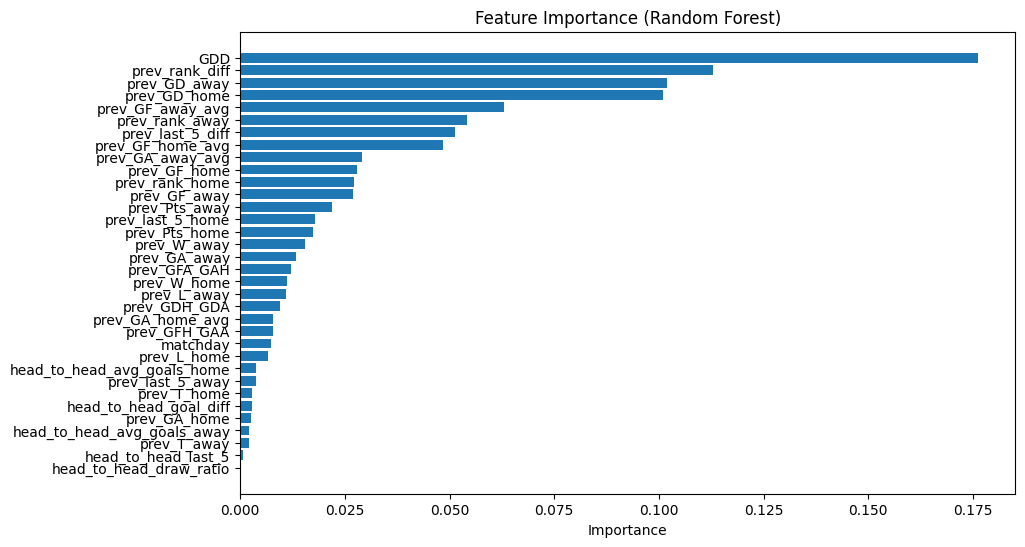

In [60]:
# select X, being all the numerical features available in the training dataset except some columns
X = balanced_training_data_subsampled.drop(columns=['winner', 'home_team', 'away_team', 'division', 'season', 'home_score', 'away_score']).select_dtypes(include=[np.number])
# select y being the target that we try to predict (winner)
y = balanced_training_data_subsampled["winner"]

# fit a random forest classifier to find the importance of each of the features in X
rf_model = RandomForestClassifier(n_estimators=200, random_state=1, max_depth=3)
rf_model.fit(X, y)

# get the feature importance from the random forest classifier and put them into a dataframe for easy plotting
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

For finding how important each of the features in the dataset are for predicting the outcome of the matches, a random forest classifier is fitted with all the possible features. After fitting the model, the importance of each feature can be plotted, and in that way the best features can be chosen. In the plot below it can be seen that the “GDD” is the feature with the highest importance. That means that this feature will have the most impact on predicting the outcome of the match correctly when used in fitting the model. The top 20 features with the highest importance will be used in the next part where the best subset of features is tried to be found. 

In [61]:
target = ['winner']
y_train = balanced_training_data_subsampled[target].values.ravel()
y_test = testing_data_1[target].values.ravel()


accuracy_total_list = []
features_list = []

# Parameters for randomized search
num_combinations = 1000  # Number of random subsets to try
min_features = 5       # Minimum number of features in a subset
max_features = 9       # Maximum number of features in a subset

all_features = feature_importance_df['Feature'].to_list()[0:20]
for i in range(num_combinations):
    print(i)
    # Randomly select a subset of features
    num_features = np.random.randint(min_features, max_features + 1)
    feature_subset = sample(list(all_features), num_features)

    features_list.append(feature_subset)
    
    X_train = X[feature_subset]
    X_test = testing_data_1[feature_subset]
    
    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=3, random_state=1), 
        "Support Vector Machine": SVC(kernel="linear"),
        "Naive Bayes Gaussian": GaussianNB()
    }

    accuracy_list = []
    
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Classification report
        report = classification_report(y_test, y_pred, target_names=["Tie (0)", "Home Win (1)", "Away Win (2)"], output_dict=True)
        accuracy_list.append(report['accuracy'])

    accuracy_total_list.append(accuracy_list)

print(accuracy_total_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

The number and order of features is also really important for the outcome of a model. Taking just the top 5 most important features might not always result in the best predictions, it can be even worse than taking a combination with a lower importance. Because it takes too much time to cross validate all the possible combinations of features, here it is decided to take 1000 different feature samples with a minimum number of 5 features and a maximum number of 9 features. These limits have been chosen because too little features will probably not give good results, and too many features might make the models overfit. Going with around 5 to 9 features looks like a sweet spot that hopefully results in good predictions. The 1000 different feature samples are used to fit 4 different models: a logistic regression model, a random forest classifier, a support vector machine and a naive Bayes gaussian model. These models are all fitted with basic hyperparameters, because later better ones will be found. The accuracy for each sample and all the models will be plotted in a graph, which can be seen below. There are a few peaks in accuracy, and the 5 highest peaks will be used in the next part where better hyperparameters are found for each model.

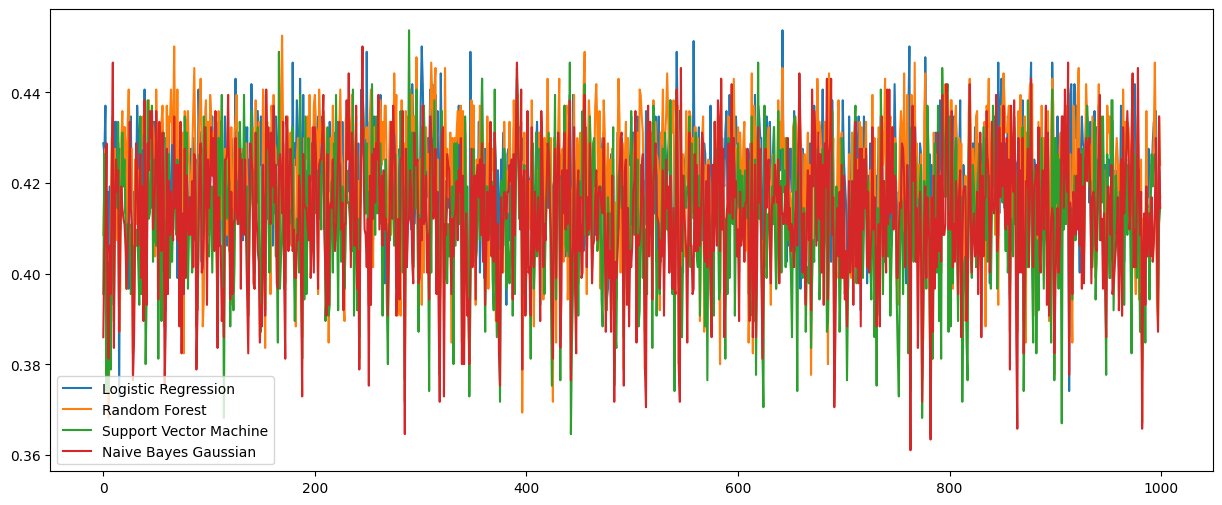

In [62]:
plt.figure(figsize=(15,6))
plt.plot(accuracy_total_list, label = ['Logistic Regression', 'Random Forest', 'Support Vector Machine', 'Naive Bayes Gaussian'])
plt.legend()
plt.show()

In [66]:
top_accuracies = []  # List to store the top 5 accuracies and their iterations

for i in range(len(accuracy_total_list)):
    for accuracy in accuracy_total_list[i]:
        # Add the accuracy and iteration to the list
        top_accuracies.append((accuracy, i))
        
        # Keep only the top 5 highest accuracies by sorting and slicing
        top_accuracies = sorted(top_accuracies, reverse=True, key=lambda x: x[0])[:5]

# Display the top 5 accuracies and their iterations
for rank, (acc, iter) in enumerate(top_accuracies, start=1):
    print(f"Rank {rank}: Accuracy = {acc}, Iteration = {iter}")


Rank 1: Accuracy = 0.45368171021377673, Iteration = 289
Rank 2: Accuracy = 0.45368171021377673, Iteration = 642
Rank 3: Accuracy = 0.4524940617577197, Iteration = 169
Rank 4: Accuracy = 0.4513064133016627, Iteration = 558
Rank 5: Accuracy = 0.4501187648456057, Iteration = 67


Each model has a few hyperparameters that can be tweaked in order to get it to predict more accurately. Depending on the complexity and customizability of the model the amount of hyperparameters varies, and to obtain the “sweetspot” ones for a certain application is not a trivial task. Some of the hyperparameters are related to very in-depth concepts about the model, while others like “max_iter” only adjust the maximum number of iterations at which the logistic regression model is set to converge.

In order to tune the hyperparameters of the models we ponder, we did a grid search, which is similar to trial and error as we learned in the lectures. There’s a dedicated function in sklearn called GridSearchCV, that is specifically designed to find the “best” hyperparameters in terms of accuracy for a certain model and training/test data sets. 

After we obtained the top 5 most accurate feature sets (from the sample), we did the grid search for each feature set applied to all 4 models we compared, selecting a specific set of hyperparameters for each model, spanning through certain values. These values were selected either from a list of possible options (for example the “kernel” hyperparameter of the SVC model can be “linear”, “rbf”,...), or were numerical values. But of course, some of the values the code searched through, we just eyeballed, because at the end of the day it’s a trial and error method.

As a result, we can see all the sets of hyperparameters for each model and ranked feature set.


In [67]:
from sklearn.model_selection import GridSearchCV

In [69]:
for rank, (acc, best_iteration) in enumerate(top_accuracies, start=1):
    print(f"Rank {rank}: Accuracy = {acc}, Iteration = {best_iteration}")
    
    feature_sel = features_list[best_iteration]
    target = ['winner']
    y_train = balanced_training_data_subsampled[target].values.ravel()
    y_test = testing_data_1[target].values.ravel()
    X_train = X[feature_sel]
    X_test = testing_data_1[feature_sel]
        
    # Grid-search Random Forest model hyperparameters
    model_RF = RandomForestClassifier(random_state=1)
    param_grid1 = {
        'max_depth': [3,4,5],
        'n_estimators': [200,275,250,225],
        'criterion': ["entropy","gini"],
        'min_samples_leaf': [2,5,7,10]
    }
    grid_search1 = GridSearchCV(estimator=model_RF, param_grid=param_grid1, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search1.fit(X_train, y_train)
            
    print("Best parameters RF:", grid_search1.best_params_)
    print("Best accuracy score RF:", grid_search1.best_score_)
    
    # Grid-search Logistic Regression model hyperparameters
    model_LR = LogisticRegression()
    param_grid2 = {
        'C': [1,1.25, 1.5, 1.75],
        'max_iter': [1000,1500,1250],
        'class_weight': ["balanced", None],
        'solver': ["lbfgs", "newton-cg", "sag"]
    }
    grid_search2 = GridSearchCV(estimator=model_LR, param_grid=param_grid2, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search2.fit(X_train, y_train)
            
    print("Best parameters LR:", grid_search2.best_params_)
    print("Best accuracy score LR:", grid_search2.best_score_)
    
    # Grid-search Support Vector Machine model hyperparameters
    model_SV = SVC()
    param_grid3 = {
        'C': [1,1.25, 1.5, 1.75],
        'kernel': ["linear", "rbf"],
        'class_weight': ["balanced", None],
        'gamma': ["scale", "auto"]
    }
    grid_search3 = GridSearchCV(estimator=model_SV, param_grid=param_grid3, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search3.fit(X_train, y_train)
            
    print("Best parameters SV:", grid_search3.best_params_)
    print("Best accuracy score SV:", grid_search3.best_score_)
    
    # Grid-search Gaussian Naive-Bayes model hyperparameters
    model_GNB = GaussianNB()
    param_grid4 = {
        'var_smoothing': [1e-4,1e-9,1e-6, 0.01, 1e-3]
    }
    grid_search4 = GridSearchCV(estimator=model_GNB, param_grid=param_grid4, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search4.fit(X_train, y_train)
            
    print("Best parameters GNB:", grid_search4.best_params_)
    print("Best accuracy score GNB:", grid_search4.best_score_)


Rank 1: Accuracy = 0.45368171021377673, Iteration = 289
Best parameters RF: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 250}
Best accuracy score RF: 0.4116853932584269
Best parameters LR: {'C': 1.75, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'lbfgs'}
Best accuracy score LR: 0.4019475655430712
Best parameters SV: {'C': 1.25, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy score SV: 0.4115355805243445
Best parameters GNB: {'var_smoothing': 0.001}
Best accuracy score GNB: 0.407191011235955
Rank 2: Accuracy = 0.45368171021377673, Iteration = 642
Best parameters RF: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}
Best accuracy score RF: 0.4169288389513108
Best parameters LR: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'newton-cg'}
Best accuracy score LR: 0.4130337078651685
Best parameters SV: {'C': 1.5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'l

In [74]:
for rank, (acc, best_iteration) in enumerate(top_accuracies, start=1):
    print(f"Rank {rank}: Accuracy = {acc}, Iteration = {best_iteration}")
    print(f"Features: {features_list[best_iteration]}\n")

Rank 1: Accuracy = 0.45368171021377673, Iteration = 289
Features: ['prev_Pts_away', 'prev_last_5_diff', 'prev_GF_away', 'prev_rank_home', 'prev_GA_away_avg', 'prev_rank_away', 'prev_GFA_GAH', 'prev_last_5_home', 'prev_GA_away']

Rank 2: Accuracy = 0.45368171021377673, Iteration = 642
Features: ['prev_Pts_home', 'prev_GF_away_avg', 'prev_GF_home_avg', 'prev_GFA_GAH', 'prev_rank_away', 'GDD', 'prev_W_away']

Rank 3: Accuracy = 0.4524940617577197, Iteration = 169
Features: ['prev_GA_away', 'GDD', 'prev_W_away', 'prev_GF_away', 'prev_rank_away', 'prev_GFA_GAH', 'prev_Pts_home', 'prev_GF_home']

Rank 4: Accuracy = 0.4513064133016627, Iteration = 558
Features: ['prev_GF_away', 'prev_GF_home_avg', 'prev_W_away', 'prev_rank_away', 'prev_Pts_home', 'prev_GF_away_avg', 'prev_W_home']

Rank 5: Accuracy = 0.4501187648456057, Iteration = 67
Features: ['prev_W_home', 'prev_rank_away', 'prev_GA_away_avg', 'prev_Pts_away', 'GDD']



These are the feature sets that correspond to the top 5 ranked accuracies.

## Step 3: Model Comparison
Like said before, the models that we use are a logistic regression model, a random forest classifier, a support vector machine and a naive Bayes gaussian model. We choose these four models because they all have their own weaknesses and strengths that hopefully makes the results different so the best one can be chosen. To compare the models, they are fitted 5 different times with the 5 feature subsets that had the highest accuracy in step 2. The hyperparameters are tuned by the last part of step 2, so they are the best for the given subset of features. The accuracy of each model on each subset is shown below, and also a confusion matrix for every option is visible there. The confusion matrices are important, because with only the accuracy it is not really sure if the model is actually good. If a model has an accuracy of 48%, but that is because the majority of the data is home wins, and the model just always predicts home wins, then the model is not really good. The confusion matrix will show that the model only predicts home wins, and in that way the model can be discarded. If the confusion matrix shows a nice diagonal, meaning that it predicts a lot of ties as ties, home wins as home wins and away wins as away wins, but the accuracy is 45%, this model is still better than the last model described. 

What we can see from all these matrices and accuracies, is that Logistic regression model with feature subset *['prev_GF_away', 'prev_GF_home_avg', 'prev_W_away', 'prev_rank_away', 'prev_Pts_home', 'prev_GF_away_avg', 'prev_W_home']* (rank 4)  has an accuracy of 45% and the confusion matrix has a pretty good diagonal. This means that this model with that specific feature subset will be the model that will be used in the final program that will predict for a matchday what the results of the matches will be. Also, there was another configuration with similar accuracy in rank 2, but we chose this specific one because the f-score looked slightly better.


In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Rank 1: Accuracy = 0.45368171021377673, Iteration = 289
Logistic Regression
Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.37      0.35       241
           1       0.52      0.48      0.50       358
           2       0.42      0.42      0.42       243

    accuracy                           0.43       842
   macro avg       0.42      0.42      0.42       842
weighted avg       0.44      0.43      0.43       842



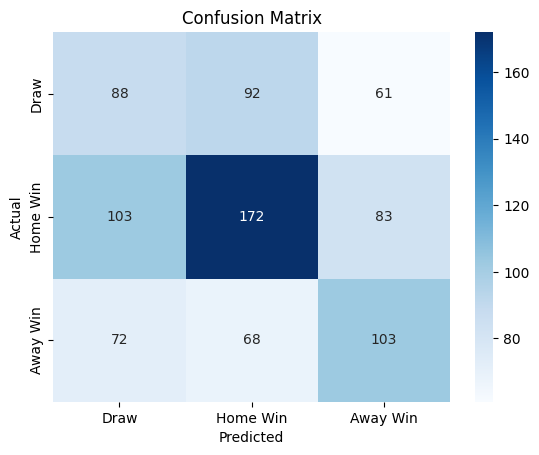

Random Forest
Accuracy: 0.40
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.41      0.34       241
           1       0.53      0.42      0.47       358
           2       0.43      0.38      0.40       243

    accuracy                           0.40       842
   macro avg       0.42      0.40      0.40       842
weighted avg       0.43      0.40      0.41       842



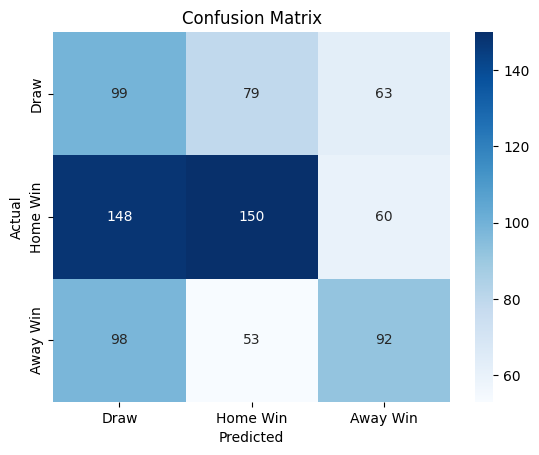

Support Vector Machine
Accuracy: 0.39
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.47      0.35       241
           1       0.52      0.41      0.46       358
           2       0.45      0.28      0.35       243

    accuracy                           0.39       842
   macro avg       0.42      0.39      0.39       842
weighted avg       0.43      0.39      0.40       842



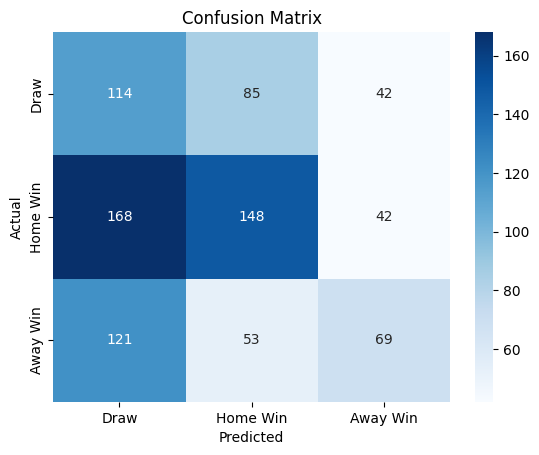

Naive Bayes Gaussian
Accuracy: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.32      0.31       241
           1       0.51      0.53      0.52       358
           2       0.40      0.34      0.37       243

    accuracy                           0.42       842
   macro avg       0.40      0.40      0.40       842
weighted avg       0.42      0.42      0.42       842



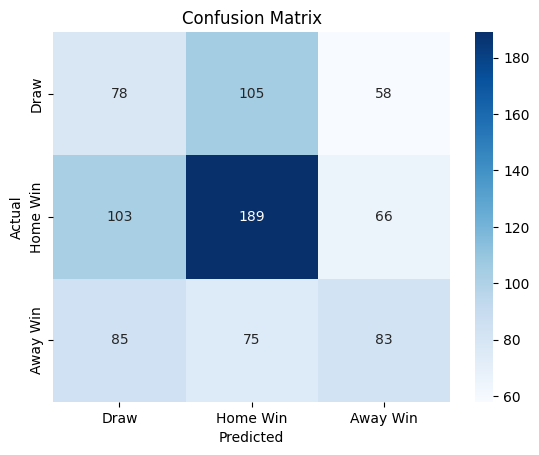

Rank 2: Accuracy = 0.45368171021377673, Iteration = 642
Logistic Regression
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.35      0.36       241
           1       0.54      0.49      0.51       358
           2       0.42      0.51      0.46       243

    accuracy                           0.45       842
   macro avg       0.44      0.45      0.44       842
weighted avg       0.46      0.45      0.45       842



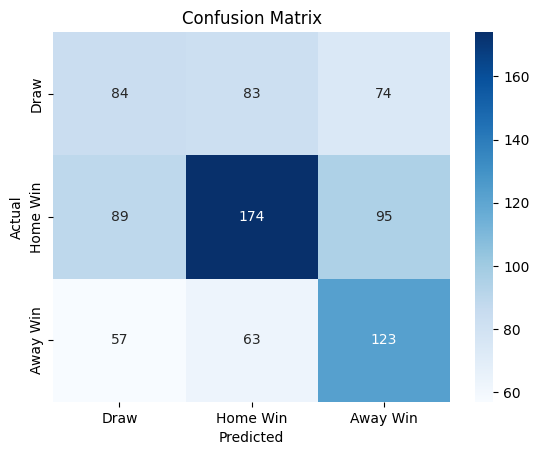

Random Forest
Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.55      0.41       241
           1       0.56      0.43      0.48       358
           2       0.47      0.32      0.38       243

    accuracy                           0.43       842
   macro avg       0.45      0.43      0.43       842
weighted avg       0.47      0.43      0.43       842



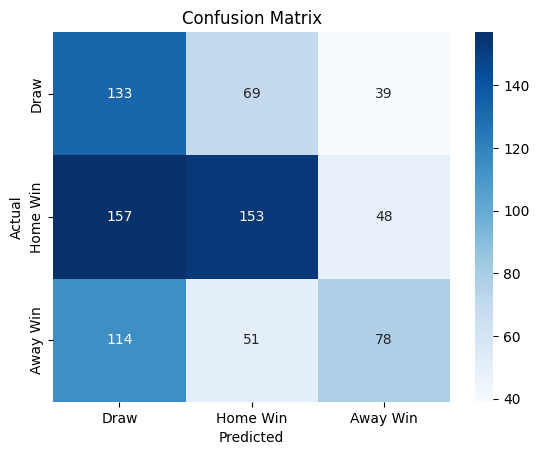

Support Vector Machine
Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.41      0.36       241
           1       0.51      0.53      0.52       358
           2       0.45      0.30      0.36       243

    accuracy                           0.43       842
   macro avg       0.43      0.41      0.41       842
weighted avg       0.44      0.43      0.43       842



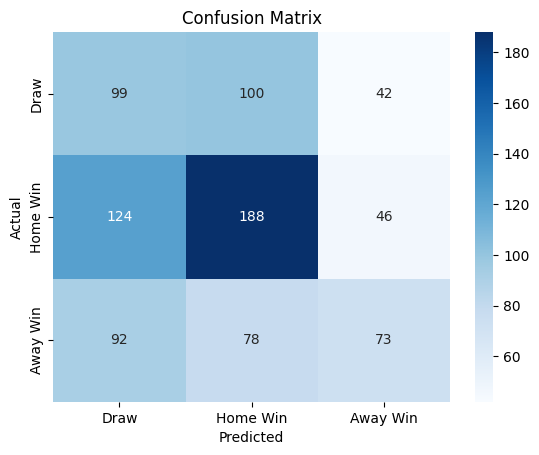

Naive Bayes Gaussian
Accuracy: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.24      0.26       241
           1       0.48      0.57      0.52       358
           2       0.44      0.37      0.40       243

    accuracy                           0.42       842
   macro avg       0.40      0.40      0.39       842
weighted avg       0.41      0.42      0.41       842



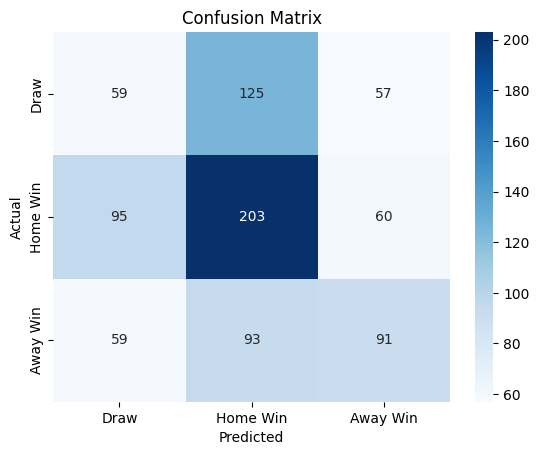

Rank 3: Accuracy = 0.4524940617577197, Iteration = 169
Logistic Regression
Accuracy: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.44      0.36       241
           1       0.51      0.39      0.44       358
           2       0.45      0.43      0.44       243

    accuracy                           0.41       842
   macro avg       0.43      0.42      0.42       842
weighted avg       0.44      0.41      0.42       842



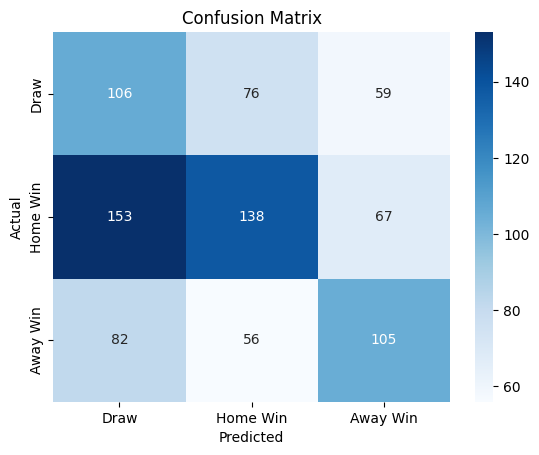

Random Forest
Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.46      0.39       241
           1       0.52      0.49      0.50       358
           2       0.47      0.35      0.40       243

    accuracy                           0.44       842
   macro avg       0.44      0.43      0.43       842
weighted avg       0.45      0.44      0.44       842



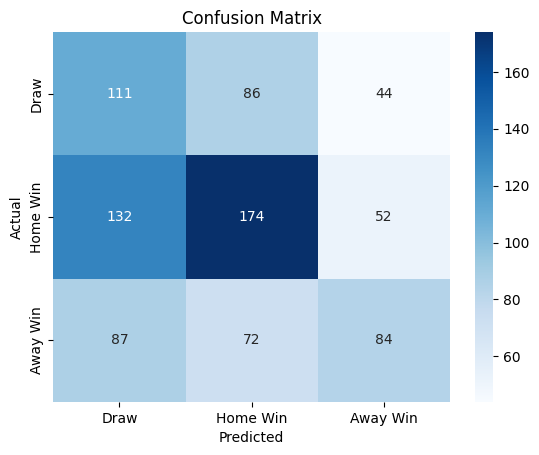

Support Vector Machine
Accuracy: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.44      0.36       241
           1       0.51      0.45      0.48       358
           2       0.44      0.31      0.37       243

    accuracy                           0.41       842
   macro avg       0.42      0.40      0.40       842
weighted avg       0.43      0.41      0.41       842



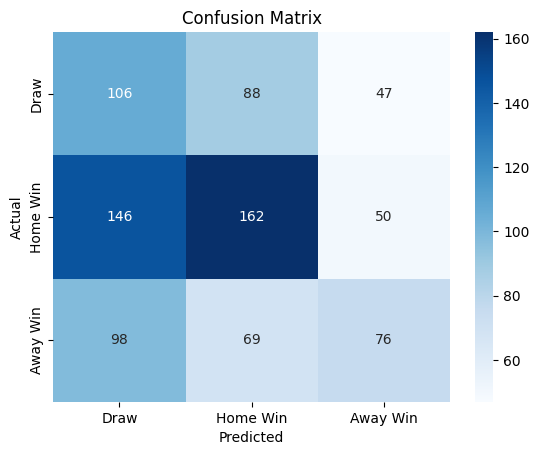

Naive Bayes Gaussian
Accuracy: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.41      0.35       241
           1       0.50      0.47      0.48       358
           2       0.46      0.34      0.39       243

    accuracy                           0.41       842
   macro avg       0.42      0.40      0.41       842
weighted avg       0.43      0.41      0.42       842



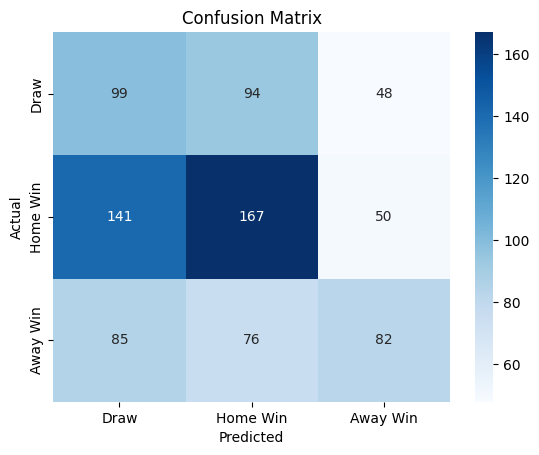

Rank 4: Accuracy = 0.4513064133016627, Iteration = 558
Logistic Regression
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.41      0.38       241
           1       0.55      0.50      0.52       358
           2       0.42      0.42      0.42       243

    accuracy                           0.45       842
   macro avg       0.44      0.44      0.44       842
weighted avg       0.46      0.45      0.45       842



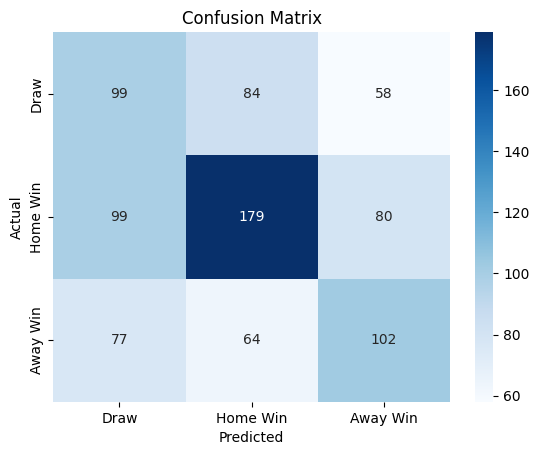

Random Forest
Accuracy: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.49      0.37       241
           1       0.53      0.43      0.47       358
           2       0.49      0.32      0.38       243

    accuracy                           0.41       842
   macro avg       0.44      0.41      0.41       842
weighted avg       0.45      0.41      0.42       842



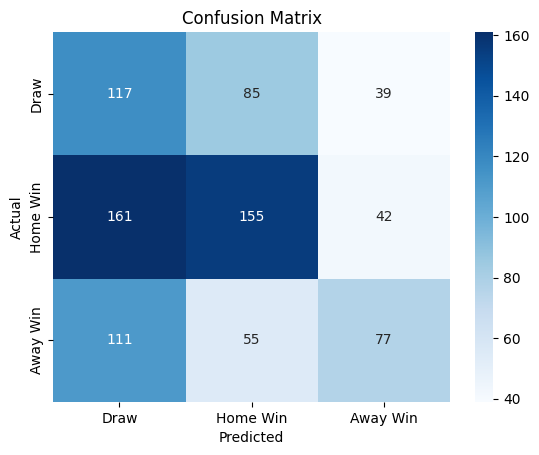

Support Vector Machine
Accuracy: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.46      0.37       241
           1       0.51      0.47      0.49       358
           2       0.46      0.27      0.34       243

    accuracy                           0.41       842
   macro avg       0.43      0.40      0.40       842
weighted avg       0.44      0.41      0.41       842



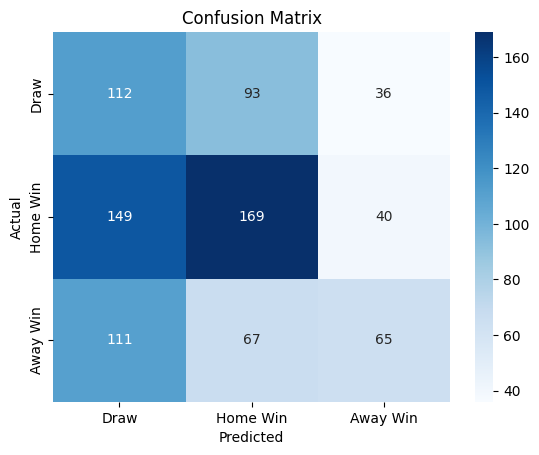

Naive Bayes Gaussian
Accuracy: 0.40
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.44      0.35       241
           1       0.51      0.43      0.47       358
           2       0.44      0.30      0.36       243

    accuracy                           0.40       842
   macro avg       0.41      0.39      0.39       842
weighted avg       0.43      0.40      0.40       842



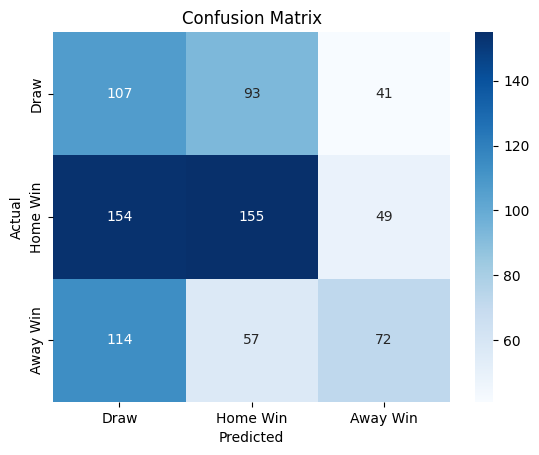

Rank 5: Accuracy = 0.4501187648456057, Iteration = 67
Logistic Regression
Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.23      0.27       241
           1       0.52      0.50      0.51       358
           2       0.41      0.54      0.47       243

    accuracy                           0.43       842
   macro avg       0.41      0.42      0.41       842
weighted avg       0.43      0.43      0.43       842



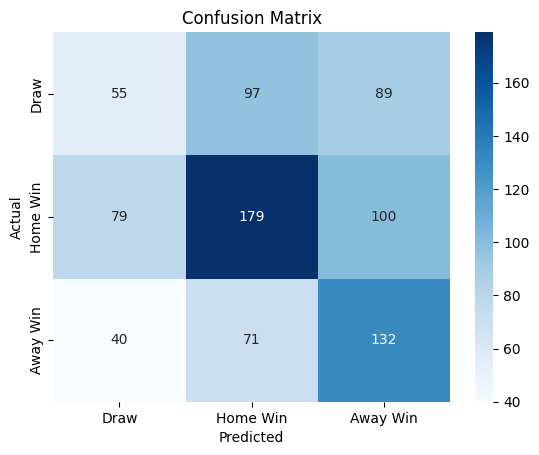

Random Forest
Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.44      0.37       241
           1       0.52      0.49      0.51       358
           2       0.48      0.33      0.39       243

    accuracy                           0.43       842
   macro avg       0.44      0.42      0.42       842
weighted avg       0.45      0.43      0.43       842



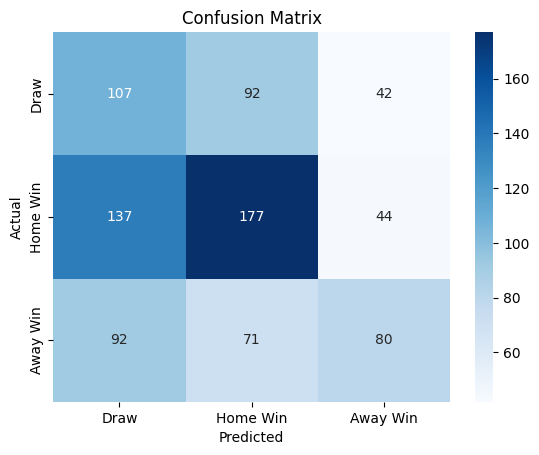

Support Vector Machine
Accuracy: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.33      0.30       241
           1       0.51      0.49      0.50       358
           2       0.43      0.36      0.39       243

    accuracy                           0.41       842
   macro avg       0.40      0.39      0.40       842
weighted avg       0.42      0.41      0.41       842



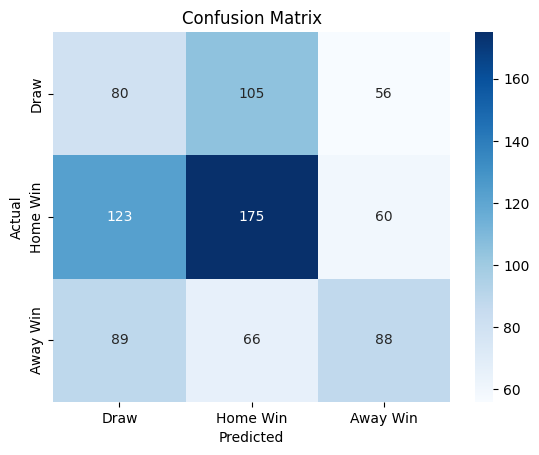

Naive Bayes Gaussian
Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.26      0.28       241
           1       0.49      0.52      0.51       358
           2       0.43      0.47      0.45       243

    accuracy                           0.43       842
   macro avg       0.41      0.42      0.41       842
weighted avg       0.42      0.43      0.43       842



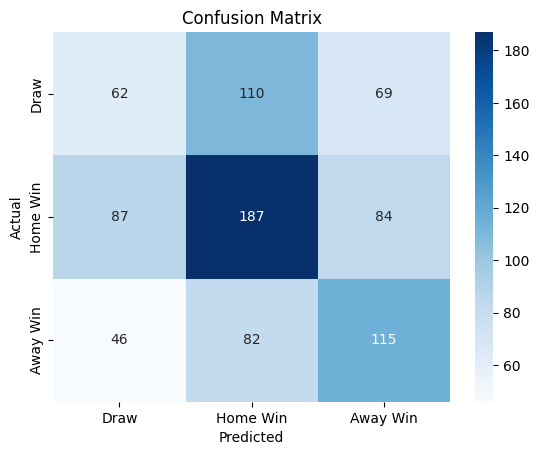

In [77]:
#features = ['GDD','prev_rank_home','prev_rank_away','prev_rank_diff','prev_GD_home','prev_GD_away','prev_last_5_diff']


for rank, (acc, best_iteration) in enumerate(top_accuracies, start=1):
    print(f"Rank {rank}: Accuracy = {acc}, Iteration = {best_iteration}")
    
    features = features_list[best_iteration]
    target = ['winner']
    
    X_train = balanced_training_data_subsampled[features]
    y_train = balanced_training_data_subsampled[target].values.ravel()
    X_test = testing_data_1[features]
    y_test = testing_data_1[target].values.ravel()
    
    # Define models
    if rank == 1:
        models = {
            "Logistic Regression": LogisticRegression(C= 1.75, class_weight="balanced", max_iter= 1000, solver="lbfgs"),
            "Random Forest": RandomForestClassifier(criterion="gini", max_depth=5, min_samples_leaf=10, n_estimators=250), 
            "Support Vector Machine": SVC(C=1.25, class_weight="balanced", gamma="scale", kernel="rbf"),
            "Naive Bayes Gaussian": GaussianNB(var_smoothing=0.001)
        }
    if rank == 2:
        models = {
            "Logistic Regression": LogisticRegression(C=1, class_weight= "balanced", max_iter= 1000, solver= "newton-cg"),
            "Random Forest": RandomForestClassifier(criterion= "gini", max_depth= 5, min_samples_leaf= 5, n_estimators= 200), 
            "Support Vector Machine": SVC(C= 1.5, class_weight= "balanced", gamma= "scale", kernel= "linear"),
            "Naive Bayes Gaussian": GaussianNB(var_smoothing= 0.01)
        }
    if rank == 3:
        models = {
            "Logistic Regression": LogisticRegression(C = 1.5, class_weight =  "balanced", max_iter = 1000, solver =  "sag"),
            "Random Forest": RandomForestClassifier(criterion = "gini", max_depth = 4, min_samples_leaf = 10, n_estimators = 200), 
            "Support Vector Machine": SVC(C = 1, class_weight = "balanced", gamma = "scale", kernel = "linear"),
            "Naive Bayes Gaussian": GaussianNB(var_smoothing = 1e-09)
        }
    if rank == 4:
         models = {
            "Logistic Regression": LogisticRegression(C = 1, class_weight =  "balanced", max_iter = 1000, solver = "lbfgs"),
            "Random Forest": RandomForestClassifier(criterion = "gini", max_depth = 5, min_samples_leaf = 2, n_estimators = 250), 
            "Support Vector Machine": SVC(C = 1.5, class_weight = "balanced", gamma = "scale", kernel = "linear"),
            "Naive Bayes Gaussian": GaussianNB(var_smoothing = 1e-09)
        }        
    if rank == 5:
         models = {
            "Logistic Regression": LogisticRegression(C=1, class_weight= "balanced", max_iter= 1000, solver= "newton-cg"),
            "Random Forest": RandomForestClassifier(criterion= "entropy", max_depth= 5, min_samples_leaf= 5, n_estimators= 200), 
            "Support Vector Machine": SVC(C= 1.75, class_weight= "balanced", gamma= "scale", kernel= "rbf"),
            "Naive Bayes Gaussian": GaussianNB(var_smoothing= 0.0001)
        }
    # Train and evaluate each model
    for name, model in models.items():
        print(name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Accuracy score
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.2f}')
        
        # Classification report
        print("Classification Report:\n", classification_report(y_test, y_pred))
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=[ 'Draw','Home Win', 'Away Win'], yticklabels=[ 'Draw','Home Win', 'Away Win'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()